### 1️⃣ Pre-processing  

**Purpose:**  
Convert raw hardware output into clean, physiologically interpretable EEG signals suitable for analysis.

Raw EEG recordings are stored as amplifier ADC values. These must be converted and conditioned before any meaningful analysis can occur.

#### Steps:

1. **Scale ADC → µV**  
   - Convert amplifier units into microvolts  
   - Ensures physiological interpretability  
   - Standardizes units across recordings  

2. **Trim to Valid Experiment Window (Study-Specified)**  
   - Removes non-experimental segments  
   - Excludes high-noise transitions  
   - Ensures analysis focuses only on controlled task periods  

3. **Bandpass Filter (1–40 Hz)**  
   - Removes slow drift (<1 Hz)  
   - Removes high-frequency muscle artifacts (>40 Hz)  
   - Preserves canonical EEG rhythms (delta–gamma)  

At the end of preprocessing, the signal represents cleaned, task-aligned EEG data in physiological units.

---

### 2️⃣ Validation (Diagnostic Only)

**Purpose:**  
Demonstrate that the custom preprocessing pipeline replicates the study’s provided filtered signals.

This step ensures the modeling pipeline is built on correctly processed data.

#### Steps:

1. **Validation Against Provided `Filtered_Data`**
   - Compute Pearson correlation per channel  
   - Compute mean absolute difference  
   - Confirm waveform structure and phase alignment  

2. **Gain Factor Analysis (Visual + Quantitative)**
   - Compute channel-wise amplitude scaling factors  
   - Confirm amplitude differences are linear (approximately constant across channels)  
   - Attribute discrepancies to unit scaling rather than filtering error  

This stage is diagnostic only and is not used during feature extraction or classification.

---

### 3️⃣ Epoching (Segmentation)

**Purpose:**  
EEG is nonstationary. Features must be extracted from short, quasi-stable time windows.

Continuous EEG recordings are segmented into:

- 2-second windows  
- 1-second overlap  

This:

- Increases sample size  
- Improves stationarity  
- Enables consistent feature extraction  
- Prevents modeling on unstable long-duration signals  

Each epoch becomes one training sample.

---

### 4️⃣ Feature Extraction (Brain Representation)

**Purpose:**  
Transform waveform data into structured, physiologically meaningful descriptors suitable for machine learning.

Each epoch is converted into a feature vector composed of:

#### Frequency-Domain Features
- Absolute band power (delta, theta, alpha, beta, gamma)  
- Relative band power  

These quantify oscillatory brain dynamics.

#### Time-Domain Features
- Hjorth Activity (signal variance)  
- Hjorth Mobility (frequency proxy)  
- Hjorth Complexity (signal irregularity)  

These capture waveform dynamics beyond spectral power.

#### Complexity Features
- Spectral entropy  

Measures distribution of power across frequencies (signal organization vs randomness).

After feature extraction:

Raw waveform (samples × channels)
↓
Structured numerical feature vector

---

### 5️⃣ Classification (Condition Modeling)

**Purpose:**  
Determine whether extracted EEG features encode experimental condition differences.

#### Pipeline:

1. Build feature matrix (X) and labels (y)  
2. Standardize features  
3. Train Classifier  
4. Evaluate using GroupKFold cross-validation  

This tests:

> Can condition be predicted from EEG-derived features?

The final output is a cross-validated classification accuracy representing how separable the experimental conditions are in feature space.

---

## Full Pipeline Summary

Raw EEG
↓
Pre-processing
↓
Validation (diagnostic)
↓
Epoching
↓
Feature Extraction
↓
Classification
↓
Condition Accuracy

## Notes / References
- Jurcak V, Tsuzuki D, Dan I. 10/20, 10/10, and 10/5 systems revisited: their validity as relative head-surface-based positioning systems. Neuroimage. 2007 Feb 15;34(4):1600-11.
Altahat SH. Robust EEG Channel Set for Biometric Application (Doctoral dissertation, University of Canberra).
Ravi KV, Palaniappan R. A minimal channel set for individual identification with EEG biometric using genetic algorithm. InInternational Conference on Computational Intelligence and Multimedia Applications (ICCIMA 2007) 2007 Dec 13 (Vol. 2, pp. 328-332). IEEE.
Marcel S, Millán JD. Person authentication using brainwaves (EEG) and maximum a posteriori model adaptation. IEEE transactions on pattern analysis and machine intelligence. 2007 Feb 20;29(4):743-52.
World Medical Association. World Medical Association Declaration of Helsinki. Ethical principles for medical research involving human subjects. Bulletin of the World Health Organization. 2001;79(4):373.


## Import Libraries and Set Paths

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import spectrogram

from eeg_data_engineer import  extract_features, get_feature_names
from eeg_preprocess import load_trim_file, load_and_preprocess, validate_against_reference, compare_with_reference, plot_eeg_signal, match_reference_gain
from eeg_organizer import parse_experiments, build_dataset
from eeg_analyze import compute_alpha_power, plot_alpha_distribution, evaluate_model_cv, plot_mean_roc



In [2]:
# =========================================
# Constants 
# =========================================
FS = 200  # Sampling rate in Hz
CANONICAL_CHANNELS = ['T7', 'F8', 'Cz', 'P4']  # EEG channels
SCALE_FACTOR = 15686 / 8388607  # µV per LSB (Ganglion ADC)

# =========================================
# Paths to data
# =========================================
raw_dir = Path("data/auditory-evoked-potential-eeg-biometric-dataset-1.0.0/Raw_Data")  # Raw EEG Signal
trim_file = Path("data/auditory-evoked-potential-eeg-biometric-dataset-1.0.0/data_trim.csv")  # Trim points
filtered_dir = Path("data/auditory-evoked-potential-eeg-biometric-dataset-1.0.0/Filtered_Data")  # Reference data


## 1️⃣ Signal Pre-processing & 2️⃣ Validation

Its clear that the raw data has noise. We can intoduce a bandpass filter to remove low frequencies and very high frequencies. 


Gain factors applied (rms): [540.01715601 536.35089934 542.86721262 534.10360799]

Validation Results
T7: Corr=0.886351 | MeanAbsDiff=1.3595 µV
F8: Corr=0.960316 | MeanAbsDiff=1.5553 µV
Cz: Corr=0.904610 | MeanAbsDiff=1.3892 µV
P4: Corr=0.907138 | MeanAbsDiff=1.2437 µV


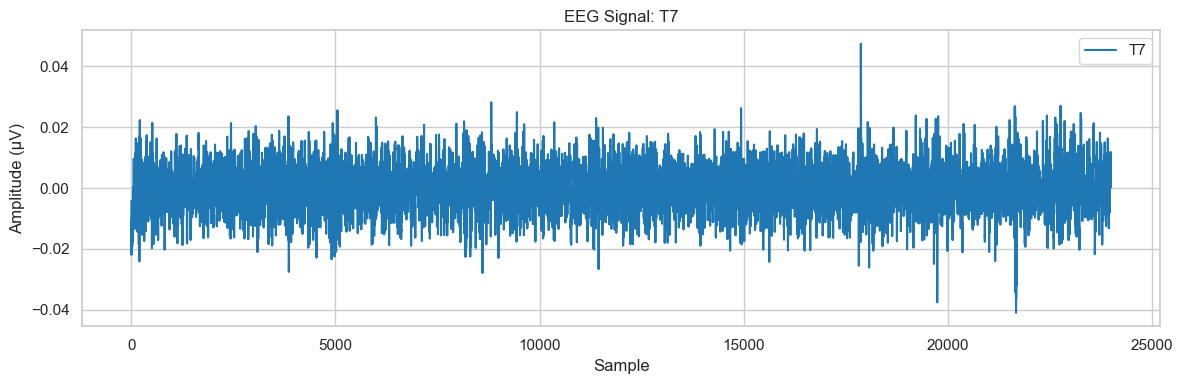

In [3]:
# Preprocess raw EEG like PhysioNet
trim_df = load_trim_file(trim_file)

subject = 1
experiment = 1   # numeric, as in data_trim.csv
session = 1

raw_file = raw_dir / "ex01" / "s01_ex01_s01.txt"
ref_file = filtered_dir / "s01_ex01_s01.csv"

# 1️⃣ Pure preprocessing (N validation inside)
eeg_proc = load_and_preprocess(
    raw_file, 
    trim_df, 
    subject=subject, 
    experiment=experiment, 
    session=session, 
)

# 2️⃣ Validation step (Compare channels and match gain)
eeg_validated = validate_against_reference(
    eeg_proc,
    reference_file=ref_file,
    apply_gain=True,        # Only for validation
    method="rms",
)

# Plot T7
plot_eeg_signal(eeg_proc, channel=0)


Gain factors: [540.01715601 536.35089934 542.86721262 534.10360799]


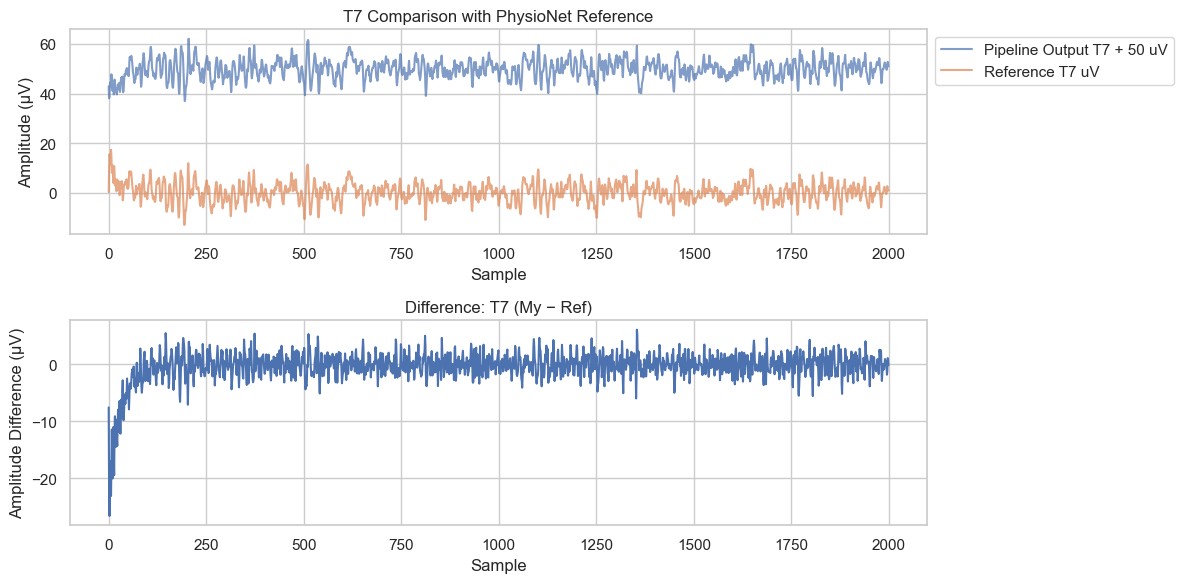

T7 max diff: 26.59921 µV | mean diff: -0.34824 µV


In [4]:
# --- Load reference ---
df_ref = pd.read_csv(ref_file)
ref_eeg = df_ref[CANONICAL_CHANNELS].to_numpy()

# --- Gain match using max amplitude ---
eeg_scaled, gain = match_reference_gain(eeg_proc, ref_eeg, method="rms")
print("Gain factors:", gain)

# --- Visual comparison ---
compare_with_reference(
    eeg_scaled,
    reference_file=ref_file,
    channel=0,
    window=10 * FS,
    show_diff=True,
    save_fig=False, 
    save_dir=("figures/pipeline_vs_reference.png")
)

The Pre-processing steps have been deduced to be as  for the Physionet dataset: 

Raw EEG
 ↓
Bandpass Filter (0.5–40 Hz)
 ↓
Amplification (gain matching)

The amplication is typically done the hardware scaling. The filtered EEGs are already scaled while the raw amplifier units are not scaled. To best match it to validate the pre-processing I performed a gain match using RMS difference. 
They should not be identically but highly correlated with eachother which they are. 

Validation Results
T7: Corr=0.886351 | MeanAbsDiff=1.3595 µV
F8: Corr=0.960316 | MeanAbsDiff=1.5553 µV
Cz: Corr=0.904610 | MeanAbsDiff=1.3892 µV
P4: Corr=0.907138 | MeanAbsDiff=1.2437 µV

Gain factors: [540.01715601 536.35089934 542.86721262 534.10360799]

These results let us know how the pre-processing conducted by me is very similar to Physionets pre-processing. The consistent Gain factors also demonstrate that trend across the channels.

There is a suggested pipeline for [EEG pre-processing] (https://www.frontiersin.org/journals/neuroinformatics/articles/10.3389/fninf.2015.00016/full):
1. Apply Filters ✅
2. Re-reference 
3. Reject Artifacts
4. Select Window Sizes ✅ 
5. Frequency Domain Decomposition
6. Average

The study has already done filter application with a Bandpass and Notch filter. They selected trim points that have minimal noise during the performed events. These steps are steps 1 and 4.

Steps 2 and 3 are not needed because re-referencing would alter our validation. Since we already selected a window where some 'event' occured there is no need to unintentionally remove important eye blinks or signal from listening to music.


In [5]:
# --- Comparison plot with overlay for all channels ---
CHANNELS = ['T7', 'F8', 'Cz', 'P4']

def compare_all_channels_overlay(my_eeg):
    """
    Overlay all EEG channels (stacked) comparing custom preprocessing
    vs PhysioNet filtered reference.
    
    Parameters
    ----------
    my_eeg : np.ndarray
        Preprocessed EEG (samples x channels)
    reference_file : str or Path
        Path to PhysioNet Filtered_Data CSV
    """

    n_channels = my_eeg.shape[1]

    # Dynamic vertical offset
    offset = 8 * np.nanstd(my_eeg)

    plt.figure(figsize=(14, 7))

    for ch in range(n_channels):
        y_offset = ch * offset

        plt.plot(
            my_eeg[:, ch] + y_offset,
            color=f"C{ch}",
            label=CHANNELS[ch]
        )

    # Channel labels centered on offsets
    yticks = [ch * offset for ch in range(n_channels)]
    plt.yticks(yticks, CHANNELS)

    # 
    plt.xlabel("Sample")
    plt.ylabel("Amplitude (µV) + offset")
    plt.title("EEG Overlay")

    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


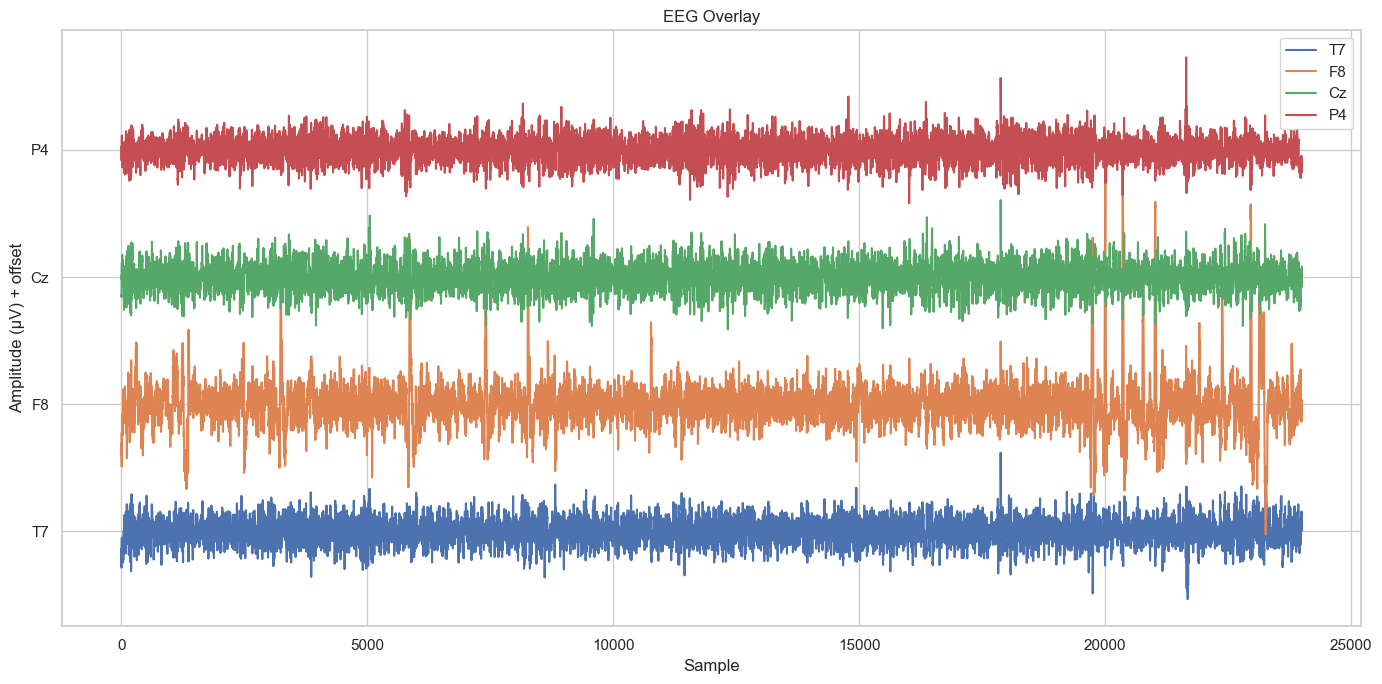

In [6]:
compare_all_channels_overlay(my_eeg=eeg_proc)

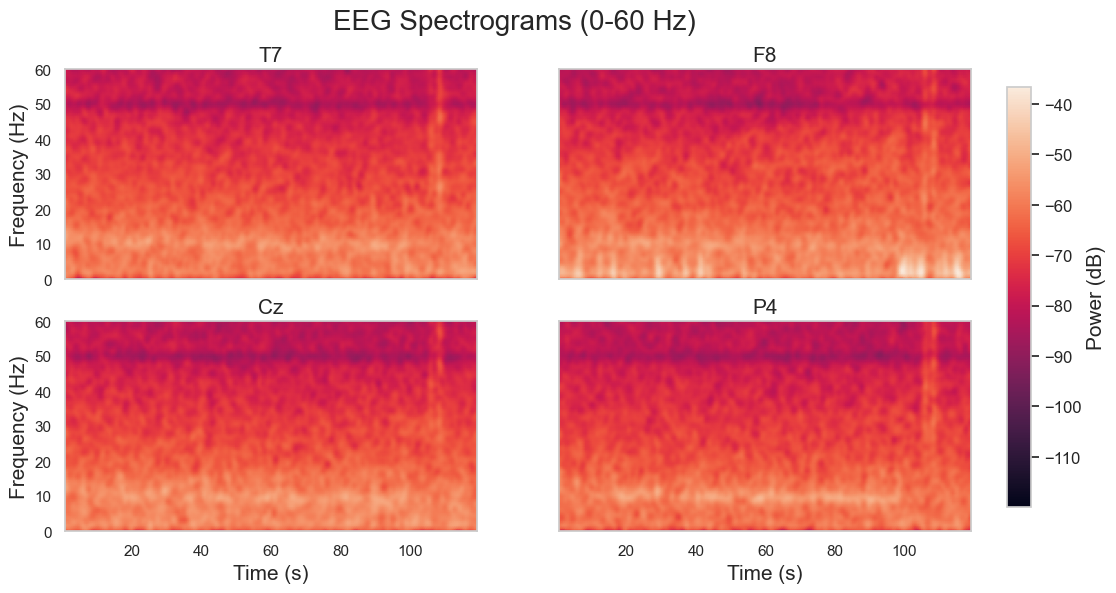

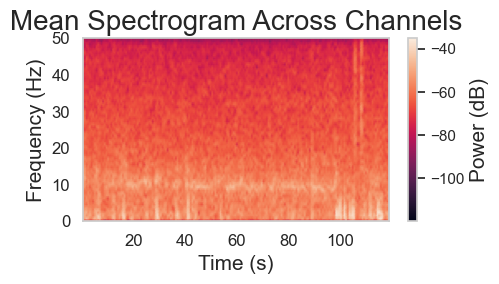

In [7]:
from eeg_analyze import plot_channel_spectrograms, plot_mean_spectrogram
# --- Spectrogram for individual channel ---
plot_channel_spectrograms(eeg_proc, channels=CANONICAL_CHANNELS, fs=FS, smoothing='gaussian', sigma=1.0, save_fig=True, save_path="figures/channel_spectrograms_ex.png")
# --- Mean spectrogram across channels ---
plot_mean_spectrogram(eeg_proc, fs=FS, smoothing='gaussian', sigma=1, save_fig=True, save_path="figures/mean_spectrogram_ex.png")

## 3️⃣ Epoching

We need to convert the continous EEG (samples x channels) into Epochs (n_epochs x epoch_samples x channels).

As a result we get a structured training sample.

In [17]:
from eeg_data_engineer import epoch_eeg

epochs = epoch_eeg(eeg_proc, fs=FS, epoch_length_sec=2.0, overlap_sec=1.0)

print(f"Epochs shape: {epochs.shape} (n_epochs, epoch_samples, n_channels)")

Epochs shape: (119, 400, 4) (n_epochs, epoch_samples, n_channels)


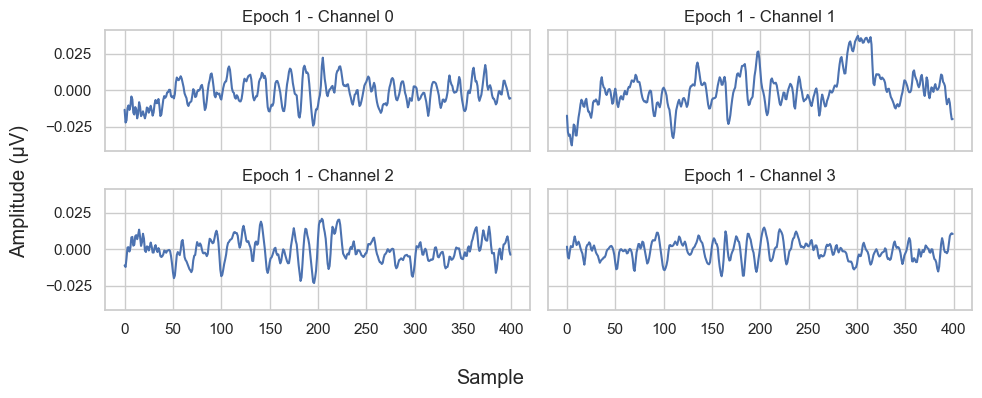

In [18]:
# Sanity check
import matplotlib.pyplot as plt

# Lets plot a couple examples of the epochs to see if they look reasonable

# Define Figure and Axes for 4 subplots (2x2)
fig, ax = plt.subplots(figsize=(10, 4), ncols=2, nrows=2, sharex=True, sharey=True, facecolor='white')

# Plot first epoch, first channel
ax[0, 0].plot(epochs[0, :, 0]) 
ax[0, 0].set_title("Epoch 1 - Channel 0")

# Plot first epoch, second channel
ax[0, 1].plot(epochs[0, :, 1]) 
ax[0, 1].set_title("Epoch 1 - Channel 1")

# Plot first epoch, third channel
ax[1, 0].plot(epochs[0, :, 2]) 
ax[1, 0].set_title("Epoch 1 - Channel 2")

# Plot first epoch, fourth channel
ax[1, 1].plot(epochs[0, :, 3]) 
ax[1, 1].set_title("Epoch 1 - Channel 3")

# Define common labels and layout
fig.supxlabel("Sample")
fig.supylabel("Amplitude (µV)")

plt.tight_layout()
plt.show()

Converted the following:

* 1 long signal → many structured training samples
* Made EEG locally stationary
* Increased dataset size
* Enabled feature extraction per window

## 4️⃣ Feature Extraction

Will build a function extract_features() that converts:

(n_epochs, epoch_samples, n_channels) into (n_epochs, n_features)

This will include:
* Absolute band power
* Relative band power
* Hjorth Parameters
* Spectral Entropy

| Feature Type        | Question It Answers                              |
| ------------------- | ------------------------------------------------ |
| Absolute Band Power | How strong is oscillation X?                     |
| Relative Band Power | What percentage of activity is oscillation X?    |
| Hjorth Activity     | How large is the signal overall?                 |
| Hjorth Mobility     | How fast is the signal changing?                 |
| Hjorth Complexity   | How irregular is the waveform?                   |
| Spectral Entropy    | How organized vs noisy is the frequency content? |

All per channel

Nayak, C. S., & Anilkumar, A. C. (2019, March 24). EEG Normal Waveforms. Nih.gov; StatPearls Publishing. https://www.ncbi.nlm.nih.gov/books/NBK539805/

Safi, M. S., & Safi, S. M. M. (2021). Early detection of Alzheimer’s disease from EEG signals using Hjorth parameters. Biomedical Signal Processing and Control, 65, 102338. https://doi.org/10.1016/j.bspc.2020.102338

### Helper Functions

### Main Feature Extraction Function

We have:
* 4 channels
* 5 bands

Features per channel:
* 5 absolute
* 5 relative
* 3 Hjorth
* 1 entropy
= 14 features per channel

The shape of the Feature matrix should be:

4 channels x 14 = 56 features per epoch

(n_epochs, 56)

In [19]:
X = extract_features(epochs, fs=FS)

print("Feature matrix shape:", X.shape)

Feature matrix shape: (119, 56)


In [20]:
import pandas as pd

feature_names = get_feature_names(n_channels=epochs.shape[2])

df_features = pd.DataFrame(X, columns=feature_names)

df_features.head()

,ch0_abs_delta,ch0_abs_theta,ch0_abs_alpha,ch0_abs_beta,ch0_abs_gamma,ch0_rel_delta,ch0_rel_theta,ch0_rel_alpha,ch0_rel_beta,ch0_rel_gamma,...,ch3_abs_gamma,ch3_rel_delta,ch3_rel_theta,ch3_rel_alpha,ch3_rel_beta,ch3_rel_gamma,ch3_hjorth_activity,ch3_hjorth_mobility,ch3_hjorth_complexity,ch3_spectral_entropy
0,0.000005,0.000012,0.000041,0.000023,0.000002,0.062333,0.138674,0.470871,0.270539,0.026644,...,0.000001,0.082884,0.056301,0.374586,0.425373,0.024683,0.000040,0.479812,1.728520,3.312929
1,0.000005,0.000010,0.000010,0.000016,0.000003,0.105231,0.216079,0.216355,0.366740,0.062953,...,0.000002,0.260963,0.111996,0.266514,0.218260,0.052992,0.000033,0.443403,2.112736,3.370335
2,0.000021,0.000007,0.000016,0.000011,0.000002,0.358878,0.124245,0.274941,0.189632,0.037187,...,0.000002,0.246970,0.162630,0.285529,0.197308,0.077313,0.000025,0.466910,2.164751,3.543832
3,0.000004,0.000002,0.000011,0.000011,0.000002,0.137550,0.068996,0.346846,0.343108,0.076609,...,0.000001,0.089888,0.137363,0.456816,0.203596,0.068562,0.000026,0.458825,2.102876,3.377964
4,0.000008,0.000006,0.000011,0.000009,0.000002,0.222944,0.150495,0.308556,0.246049,0.055893,...,0.000001,0.138039,0.149617,0.302363,0.320365,0.044483,0.000040,0.456091,1.844830,3.432679


In [21]:
df_features.describe()

,ch0_abs_delta,ch0_abs_theta,ch0_abs_alpha,ch0_abs_beta,ch0_abs_gamma,ch0_rel_delta,ch0_rel_theta,ch0_rel_alpha,ch0_rel_beta,ch0_rel_gamma,...,ch3_abs_gamma,ch3_rel_delta,ch3_rel_theta,ch3_rel_alpha,ch3_rel_beta,ch3_rel_gamma,ch3_hjorth_activity,ch3_hjorth_mobility,ch3_hjorth_complexity,ch3_spectral_entropy
count,1.190000e+02,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,...,1.190000e+02,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,1.013872e-05,0.000008,0.000020,0.000011,0.000003,0.185305,0.152795,0.370311,0.214349,0.050152,...,1.965503e-06,0.139531,0.125698,0.467673,0.190950,0.044720,0.000050,0.424657,1.974175,3.070859
std,8.752121e-06,0.000004,0.000012,0.000004,0.000003,0.115971,0.062150,0.143887,0.070301,0.029631,...,2.867132e-06,0.092370,0.062788,0.201922,0.087078,0.045853,0.000020,0.081859,0.156886,0.394418
min,8.961554e-07,0.000002,0.000003,0.000005,0.000001,0.033876,0.047396,0.055617,0.075746,0.012629,...,9.257713e-07,0.006536,0.013823,0.047958,0.065545,0.009445,0.000021,0.341307,1.486433,2.117537
25%,4.592089e-06,0.000005,0.000011,0.000008,0.000002,0.100335,0.104389,0.255761,0.166073,0.033252,...,1.329017e-06,0.074297,0.080731,0.284152,0.126000,0.021932,0.000035,0.384339,1.877896,2.780806
50%,7.563681e-06,0.000007,0.000017,0.000010,0.000002,0.162607,0.145322,0.374531,0.202813,0.042487,...,1.528725e-06,0.119004,0.111860,0.471168,0.167870,0.034834,0.000049,0.405333,1.948663,3.131418
75%,1.230164e-05,0.000010,0.000026,0.000012,0.000003,0.245330,0.198957,0.496853,0.261024,0.060925,...,1.854374e-06,0.185674,0.164055,0.646719,0.239289,0.048921,0.000058,0.443138,2.049556,3.359438
max,4.235475e-05,0.000024,0.000074,0.000029,0.000029,0.568419,0.384134,0.669639,0.450669,0.273053,...,2.793832e-05,0.429538,0.289636,0.875136,0.467605,0.358622,0.000132,0.903408,2.483142,4.213994


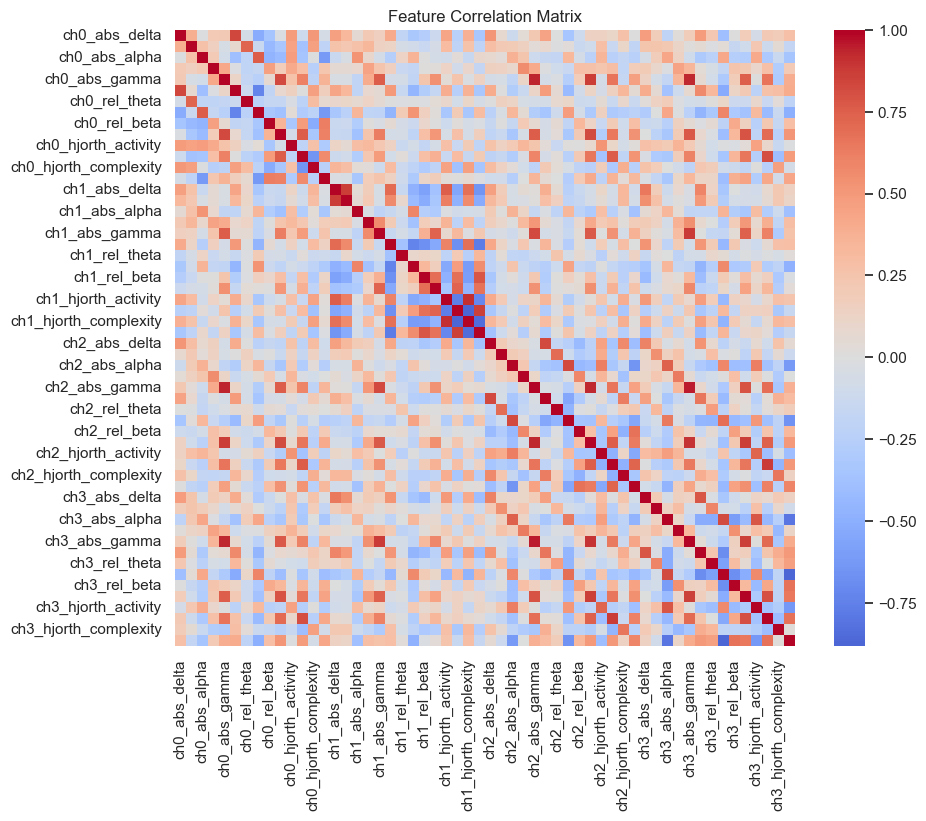

In [22]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(df_features.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")
plt.show()

I built a representation of:
* Oscillation strength
* Oscillation proportion
* Signal speed
* Signal irregularity
* Frequency disorder

A low-level EEG description.

**Why extract features?**

Raw signal is better when:
* You have large dataset
* You want highest possible accuracy
* You don’t care about interpretability

Since interpretability is important classical machine learning with neuroscientific descriptors makes this process interpretable

It is:
* Data efficient
* Interpretable
* Dimensionality Reduction

|Approach     |Pros                           |Cons                                   |
|-------------|-------------------------------|---------------------------------------|
|Feature-based|Interpretable, stable, low data| Might miss subtle patterns            |
|Raw-signal DL|Has higher capability          |Needs lots of data, harder to interpret|

## Dataset Builder 

The data does not come with labels however it was specified how to indenitfy the files and what was the expirement about.
With that information we can create our labels.

We can ensure some subjects are in train and completely different are in test using a grouped split 

In [23]:
# obtain experiments metadata from raw directory
experiments = parse_experiments(raw_dir)

### Build eyes open vs closed dataset
# Ensure only the relevant experiments are included
experiment_to_label = {
    "ex01": 1,  # Eyes Open
    "ex02": 0,  # Eyes Closed
}

# Build dataset using the raw data, trim points, and labels
X, y, groups = build_dataset(
    experiments,
    experiment_to_label,
    trim_df,
    fs=200
)

## 5️⃣ Classification Model

In [24]:
from sklearn.linear_model import LogisticRegression
from eeg_modeling import evaluate_model_groupkfold

logreg = LogisticRegression(max_iter=1000)

results_logreg = evaluate_model_groupkfold(
    model=logreg,
    X=X,
    y=y,
    groups=groups,
    n_splits=5
)
print(results_logreg["auc_scores"])
print(results_logreg["sensitivities"])
print(results_logreg["specificities"])

Fold 1 AUC: 0.660
Fold 2 AUC: 0.798
Fold 3 AUC: 0.638
Fold 4 AUC: 0.784
Fold 5 AUC: 0.894

===== Final Results =====
Mean AUC: 0.755 ± 0.095
Mean Sensitivity: 0.680
Mean Specificity: 0.701
[0.6603151064347308, 0.7983644438167423, 0.6384494974460372, 0.7839463734932175, 0.8943889436962904]
[np.float64(0.6876750700280112), np.float64(0.5126050420168067), np.float64(0.738795518207283), np.float64(0.6264044943820225), np.float64(0.834733893557423)]
[np.float64(0.47689075630252103), np.float64(0.8837535014005602), np.float64(0.5245098039215687), np.float64(0.8074229691876751), np.float64(0.8111739745403111)]


In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200)

results_rf = evaluate_model_groupkfold(
    model=rf,
    X=X,
    y=y,
    groups=groups,
    n_splits=5
)
print(results_rf["auc_scores"])
print(results_rf["sensitivities"])
print(results_rf["specificities"])

Fold 1 AUC: 0.618
Fold 2 AUC: 0.735
Fold 3 AUC: 0.715
Fold 4 AUC: 0.850
Fold 5 AUC: 0.941

===== Final Results =====
Mean AUC: 0.772 ± 0.112
Mean Sensitivity: 0.670
Mean Specificity: 0.714
[0.6182867754945116, 0.7347779798193786, 0.7150490097999984, 0.850147432568533, 0.9410407727447414]
[np.float64(0.4964985994397759), np.float64(0.4320728291316527), np.float64(0.7542016806722689), np.float64(0.723314606741573), np.float64(0.9439775910364145)]
[np.float64(0.6421568627450981), np.float64(0.8270308123249299), np.float64(0.5546218487394958), np.float64(0.8172268907563025), np.float64(0.7291371994342292)]


In [26]:
from sklearn.svm import SVC

svc = SVC(probability=True)  # MUST enable probability=True

results_svc = evaluate_model_groupkfold(
    model=svc,
    X=X,
    y=y,
    groups=groups,
    n_splits=5
)


Fold 1 AUC: 0.648
Fold 2 AUC: 0.782
Fold 3 AUC: 0.698
Fold 4 AUC: 0.808
Fold 5 AUC: 0.879

===== Final Results =====
Mean AUC: 0.763 ± 0.081
Mean Sensitivity: 0.693
Mean Specificity: 0.695


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


final_model_logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

# Train final model on entire dataset (no groups, no CV)
final_model_logreg.fit(X, y)

# Extract feature importance (coefficients) from logistic regression
coefs = final_model_logreg.named_steps["clf"].coef_[0]

importance_df_logreg = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs,
    "abs_importance": np.abs(coefs)
}).sort_values("abs_importance", ascending=False)

print(importance_df_logreg)

                  feature  coefficient  abs_importance
14          ch1_abs_delta    -4.183922        4.183922
15          ch1_abs_theta     2.799965        2.799965
17           ch1_abs_beta     1.978321        1.978321
35          ch2_rel_alpha    -1.728893        1.728893
52    ch3_hjorth_activity    -1.610000        1.610000
49          ch3_rel_alpha    -1.149393        1.149393
26  ch1_hjorth_complexity     1.141961        1.141961
10    ch0_hjorth_activity     1.037593        1.037593
25    ch1_hjorth_mobility     1.017465        1.017465
33          ch2_rel_delta    -0.994176        0.994176
34          ch2_rel_theta    -0.838259        0.838259
38    ch2_hjorth_activity    -0.770830        0.770830
19          ch1_rel_delta     0.699789        0.699789
23          ch1_rel_gamma     0.664721        0.664721
36           ch2_rel_beta    -0.618829        0.618829
21          ch1_rel_alpha     0.573626        0.573626
48          ch3_rel_theta    -0.569879        0.569879
39    ch2_

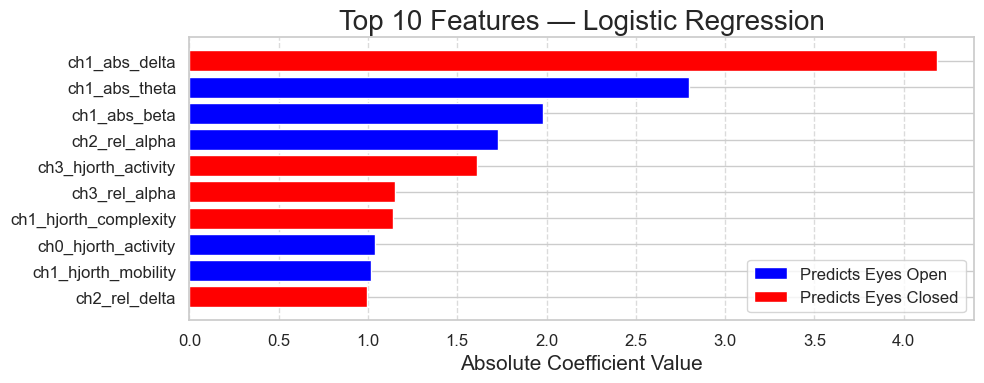

In [49]:
# Sort by absolute importance descending
coef_df = importance_df_logreg.sort_values("abs_importance", ascending=False)

## Plot top N features in a horizontal bar chart
top_n = 10
top_features = coef_df.head(top_n)
# Define figure and colors based on coefficient sign
label = 15
title = 20 
tick = 12

plt.figure(figsize=(10, 4), facecolor='white')
colors = ["red" if x < 0 else "blue" for x in top_features["coefficient"]]
# Plot top N features on bar chart
plt.barh(top_features["feature"][::-1], top_features["abs_importance"][::-1], color=colors)
plt.xlabel("Absolute Coefficient Value", fontsize=label)
plt.title(f"Top {top_n} Features — Logistic Regression", fontsize=title)
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.tick_params(axis='both', which='major', labelsize=tick)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label='Predicts Eyes Open'),
                   Patch(facecolor='red', label='Predicts Eyes Closed')]
plt.legend(handles=legend_elements, loc="lower right", fontsize=tick)

plt.tight_layout()
plt.savefig("figures/logreg_feature_importance.png")

plt.show()

In [30]:
# Retrain final model on entire dataset to get feature importance for Random Forest
final_model_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])

# Train final model on entire dataset (no groups, no CV)
final_model_rf.fit(X, y)

# Extract feature importance (coefficients) from logistic regression
coefs = final_model_rf.named_steps["clf"].feature_importances_

importance_df_rf = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs,
    "abs_importance": np.abs(coefs)
}).sort_values("abs_importance", ascending=False)

print(importance_df_rf)

                  feature  coefficient  abs_importance
18          ch1_abs_gamma     0.086519        0.086519
25    ch1_hjorth_mobility     0.035972        0.035972
23          ch1_rel_gamma     0.032699        0.032699
24    ch1_hjorth_activity     0.030877        0.030877
17           ch1_abs_beta     0.029703        0.029703
35          ch2_rel_alpha     0.028574        0.028574
21          ch1_rel_alpha     0.025855        0.025855
26  ch1_hjorth_complexity     0.023973        0.023973
38    ch2_hjorth_activity     0.021968        0.021968
4           ch0_abs_gamma     0.021792        0.021792
11    ch0_hjorth_mobility     0.021656        0.021656
30          ch2_abs_alpha     0.021205        0.021205
27   ch1_spectral_entropy     0.021130        0.021130
52    ch3_hjorth_activity     0.020128        0.020128
31           ch2_abs_beta     0.019782        0.019782
40  ch2_hjorth_complexity     0.019449        0.019449
53    ch3_hjorth_mobility     0.018063        0.018063
55   ch3_s

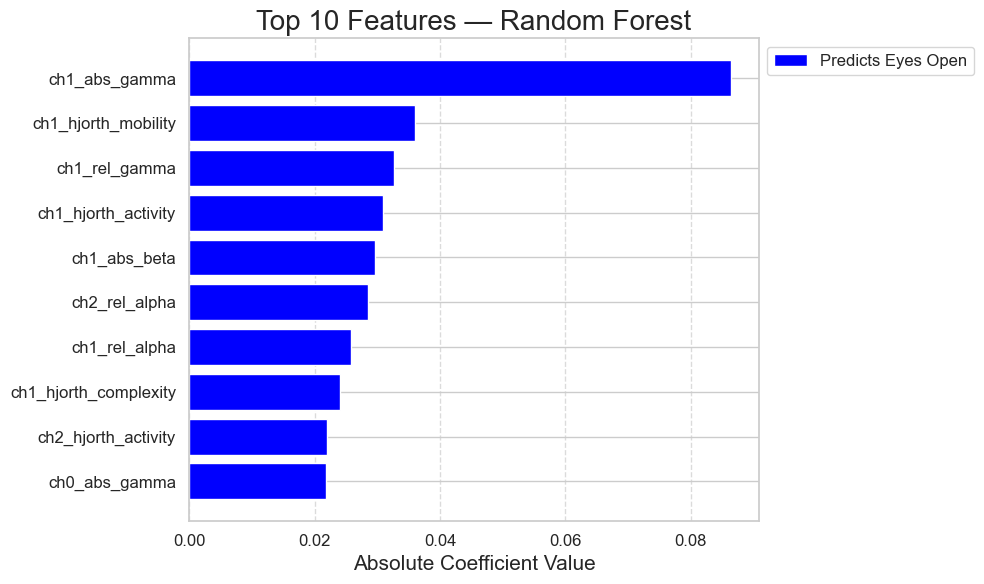

In [34]:
# Sort by absolute importance descending
coef_df = importance_df_rf.sort_values("abs_importance", ascending=False)

## Plot top N features in a horizontal bar chart
top_n = 10
top_features = coef_df.head(top_n)
# Define figure and colors based on coefficient sign
label = 15
title = 20 
tick = 12

plt.figure(figsize=(10,6), facecolor='white')
colors = ["blue" for x in top_features["coefficient"]]
# Plot top N features on bar chart
plt.barh(top_features["feature"][::-1], top_features["abs_importance"][::-1], color=colors)
plt.xlabel("Absolute Coefficient Value", fontsize=label)
plt.title(f"Top {top_n} Features — Random Forest", fontsize=title)
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.tick_params(axis='both', which='major', labelsize=tick)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label='Predicts Eyes Open')]
plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1, 1), fontsize=tick)

plt.tight_layout()
plt.show()

# Figures 

**Power Spectral Density (E0 vs EC)**
Show physiological validity:
* Alpha increase in Eyes Closed
* That your model is grounded in real signal

What To Plot
* Mean PSD across epochs
* One representative subject
* EO vs EC overlay

In [27]:
eeg_epochs_eo = []
eeg_epochs_ec = []

for ex_key in ["ex01", "ex02"]:
    files = experiments[ex_key]

    for meta in files:
        file_path = meta["path"]
        subject = meta["subject"]
        session = meta["session"]

        if session is None:
            print("Skipping missing session:", subject, ex_key)
            continue

        eeg_proc = load_and_preprocess(
            file_path,
            trim_df,
            subject,
            int(ex_key[2:]),
            session
        )

        epochs = epoch_eeg(eeg_proc, fs=FS)

        if ex_key == "ex01":
            eeg_epochs_eo.append(epochs)
        elif ex_key == "ex02":
            eeg_epochs_ec.append(epochs)
    
eeg_epochs_eo = np.vstack(eeg_epochs_eo)
eeg_epochs_ec = np.vstack(eeg_epochs_ec)

print("EO shape:", eeg_epochs_eo.shape)
print("EC shape:", eeg_epochs_ec.shape)

EO shape: (7136, 400, 4)
EC shape: (7126, 400, 4)


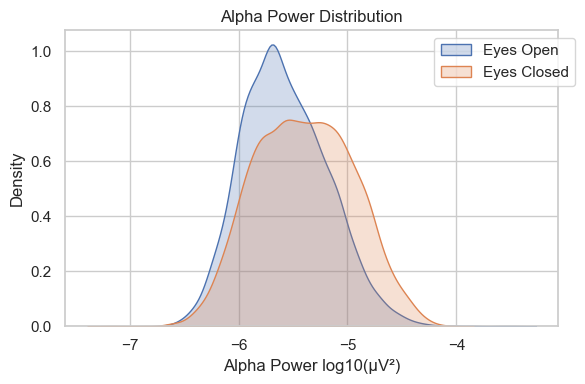

Fold 1 | AUC: 0.660 | Sens: 0.688 | Spec: 0.477
Fold 2 | AUC: 0.798 | Sens: 0.513 | Spec: 0.884
Fold 3 | AUC: 0.638 | Sens: 0.739 | Spec: 0.525
Fold 4 | AUC: 0.784 | Sens: 0.626 | Spec: 0.807
Fold 5 | AUC: 0.894 | Sens: 0.835 | Spec: 0.811

===== Final Results =====
Mean AUC: 0.755 ± 0.095
Mean Sensitivity: 0.680
Mean Specificity: 0.701


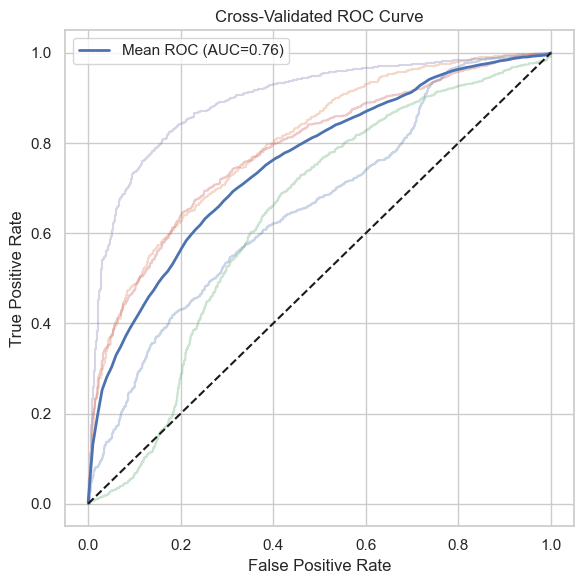

In [28]:
# ============================================================
# 7️⃣ Run the Full Pipeline
# ============================================================

# - eeg_epochs_eo, eeg_epochs_ec from your stacked epochs
# - X, y, groups from build_dataset
# - feature_names list from extract_features

# 7b. Alpha Power
alpha_eo = compute_alpha_power(eeg_epochs_eo[:,:,0])
alpha_ec = compute_alpha_power(eeg_epochs_ec[:,:,0])
plot_alpha_distribution(alpha_eo, alpha_ec, save_path="figures/alpha_distribution.png")

# 7c. Model Evaluation
trained_model, y_true_folds, y_prob_folds, auc_scores, sens, spec = evaluate_model_cv(X, y, groups)

# 7d. ROC Curve
plot_mean_roc(y_true_folds, y_prob_folds, save_path="figures/roc_curve.png")